# Linear Regression Using Python

## Theory

Suppose that you want to fit a set data points $(x_i,y_i)$, where
$i = 1,2,\ldots,N$, to a straight line, $y=ax+b$.  The process of determining the best-fit line is called <i>linear regression</i>.  This involves choosing the parameters $a$ and $b$ to minimize the sum of the squares of the differences between the data points and the linear function.  How the differences are defined varies.  If there are only uncertainties in the <i>y</i> direction, then the differences in the vertical direction (the gray lines in the figure below) are used.  If there are uncertainties in both the $x$ and $y$ directions, the orthogonal (perpendicular) distances from the line (the dotted red lines in the figure below) are used.

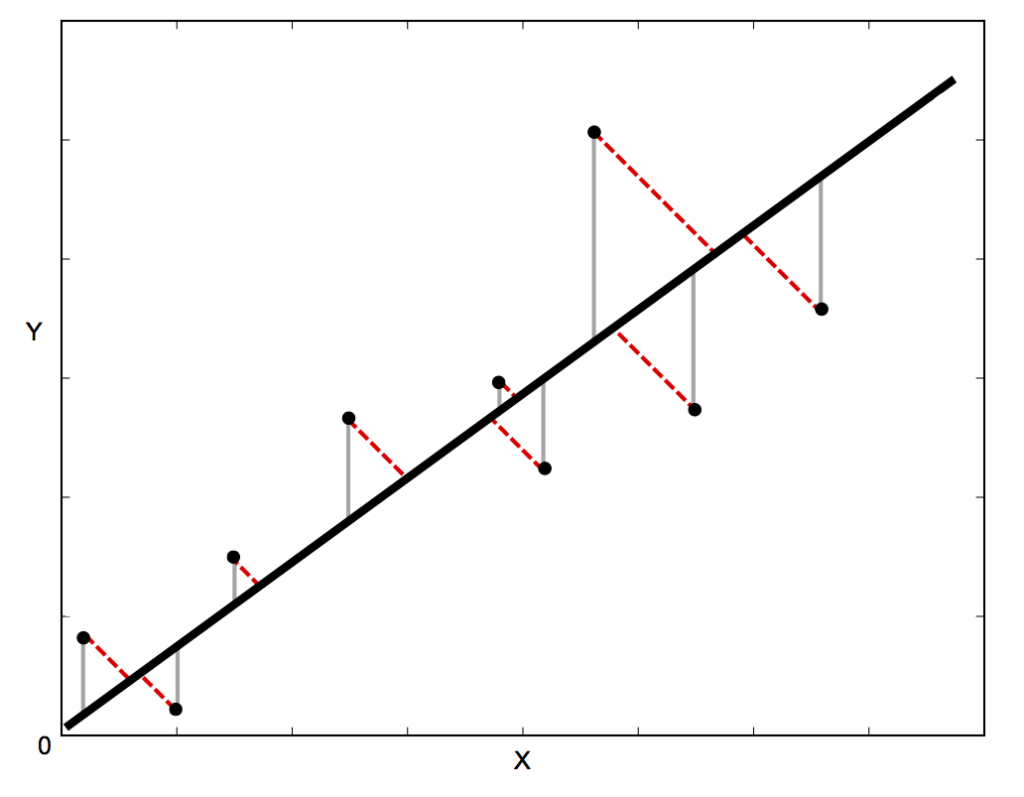

In [7]:
from IPython.display import Image
Image(filename="Normal_vs_ODR.png",width=400)

Image from http://blog.rtwilson.com/orthogonal-distance-regression-in-python/  

For the case where there are only uncertainties in the <i>y</i> direction, there is an analytical solution to the problem.  If the uncertainty in $y_i$ is $\sigma_i$, then the difference squared for each point is weighted by $w_i=1/\sigma_i^2$. If there are no uncertainties, each point is given an equal weight of one. The function to be minimized with respect to
variations in the parameters, $a$ and $b$, is  

$$
\chi^2 = \sum_{i=1}^N w_i \left[y_i - \left(ax_i+b\right)\right]^2.
$$  
The analytical solutions for the best-fit parameters that minimize $\chi^2$
(see pp. 181-189 of <i>An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements</i> by John R. Taylor, for example) are  

$$
a=\frac{\sum w_i \sum w_i x_i y_i - \sum w_i x_i \sum w_i y_i}{\sum w_i \sum w_i x_i^2 - \left(\sum w_i \sum w_i x_i\right)^2}
$$  
and
$$
b=\frac{\sum w_i y_i \sum w_i x_i^2 - \sum w_i x_i \sum w_i x_i y_i}{\sum w_i \sum w_i x_i^2 - \left(\sum w_i \sum w_i x_i\right)^2}.
$$  
The uncertainties in the parameters are  

$$
\sigma_a=\sqrt{\frac{\sum w_i}{\sum w
_i \sum w_i x_i^2 - \left(\sum w_i \sum w_i x_i\right)^2}}
$$  
and
$$
\sigma_b=\sqrt{\frac{\sum w_i x_i^2}{\sum w_i \sum w_i x_i^2 - \left(\sum w_i \sum w_i x_i\right)^2}}.
$$  
All of the sums in the four previous equations are over $i$ from 1 to $N$.  

For the case where there are uncertainties in both $x$ and $y$, there is no analytical solution. The complex method used is called <i>orthogonal distance regression</i> (ODR). 


## Implementation in Python 

The **`linear_fit`** function that performs these calculations is defined in the file "fitting.py".  The file must be located in the same directory as the Python program using it. If there are no uncertainties or only uncertainties in the $y$ direction, the analytical expressions above are used. If there are uncertainties in both the $x$ and $y$ directions, the scipy.odr module is used.

An example of performing a linear fit with uncertainties in the $y$ direction is shown below. The first command imports the function. Arrays containing the data points ($x$ and $y$) are sent to the function. If only one array of uncertainties (called $yerr$ in the example) is sent, they are assumed to be in the $y$ direction. In the example, the array
function (from the pylab library) is used to turn lists into arrays. It is also possible to read data from a file. The fitting function returns the best-fit parameters (called $a$ and $b$ in the example), their uncertainties (called $sa$ and $sb$ in the example), the reduced chi squared, and the degrees of freedom (called $rchi2$ and $dof$ in the example). The last two quantities are defined in the next section. 

In [8]:
from __future__ import print_function
from math import sqrt
from scipy import odr

def linear_fit(xdata, ydata, sigmay=None, sigmax=None):
    """
    Performs a linear fit to data.

    Parameters
    ----------
    xdata : An array of length N.
    ydata : An array of length N.

    sigmay : None or an array of length N.
    sigmax : None or an array of length N.
        If one is provided, it is the standard deviation of ydata.  Analytical linear regression used.
        If both are provided, they are the standard deviations of ydata and xdata, respectively. ODR is used.

    Returns
    -------
    a, b   : Optimal parameter of linear fit (y = a*x + b)
    sa, sb : Uncertainties of the parameters
    """

    def lin_func(p, x):
        a, b = p
        return a*x + b
    
    dof = len(ydata) - 2

    if sigmax is None:
        if sigmay is None:
            w = ones(len(ydata)) # Each point is equally weighted.
        else:
            w=1.0/(sigmay**2)

        sw = sum(w)
        wx = w*xdata # this product gets used to calculate swxy and swx2
        swx = sum(wx)
        swy = sum(w*ydata)
        swxy = sum(wx*ydata)
        swx2 = sum(wx*xdata)

        a = (sw*swxy - swx*swy)/(sw*swx2 - swx*swx)
        b = (swy*swx2 - swx*swxy)/(sw*swx2 - swx*swx)
        sa = sqrt(sw/(sw*swx2 - swx*swx))
        sb = sqrt(swx2/(sw*swx2 - swx*swx))

        if sigmay is None:
            chi2 = sum(((a*xdata + b)-ydata)**2)
        else:
            chi2 = sum((((a*xdata + b)-ydata)/sigmay)**2)
        rchi2 = chi2/dof

    else:
        # make the initial guess a line passing through first and last points
        a0 = (ydata[-1]-ydata[0])/(xdata[-1]-xdata[0])
        b0 = ydata[0]-xdata[0]*a0
        model = odr.Model(lin_func)
        data = odr.RealData(x=xdata, y=ydata, sx=sigmax, sy=sigmay)
        od = odr.ODR(data, model, [a0,b0])
        out = od.run()
        a,b = out.beta
        sa,sb = out.sd_beta
        rchi2 = out.res_var

#    From: https://www.physics.utoronto.ca/~phy326/python/odr_fit_to_data.py
#    scipy.odr scales the parameter uncertainties by the reduced chi 
#    square (out.res_var).  If the fit is poor, i.e. reduced chisq is 
#    large, the uncertainties are scaled up, which makes sense. If the 
#    fit is "too good", i.e. reduced chisq << 1, it suggests that the 
#    uncertainties may have been overestimated, but it seems risky to 
#    scale down the uncertainties. 
        if rchi2 < 1.0 :
            sa = sa/sqrt(rchi2)
            sb = sb/sqrt(rchi2)

    if sigmay is None:
        print('results of linear_fit: no uncertainties provided, so use with caution')
    else:
        print('results of linear_fit:')

#    print('   chi squared = ', chi2)
    print('   reduced chi squared = ', rchi2)
    print('   degrees of freedom = ', dof)


    return a, b, sa, sb, rchi2, dof



In [11]:
from pylab import *

# Turn lists of numbers into arrays
x = array([0.0, 2.0, 4.0, 6.0, 8.0])
y = array([1.1, 1.9, 3.2, 4.0, 5.9])
yerr = array([0.1, 0.2, 0.1, 0.3, 0.3])

a, b, sa, sb, rchi2, dof = linear_fit(x, y, yerr)

print('y = ax + b')
print('a = ', a, ' +/- ', sa)
print('b = ', b, ' +/- ', sb)

results of linear_fit:
   reduced chi squared =  1.8529522376833425
   degrees of freedom =  3
y = ax + b
a =  0.5475554719819483  +/-  0.027442716158878274
b =  1.0352012034599476  +/-  0.09253847679669566


An example of performing a linear fit with uncertainties in both the $x$ and $y$ direction is shown below. Arrays containing the data points ($x2$ and $y2$) and their uncertainties ($y2err$ and $x2err$) are sent to the function.  Note the order of the uncertainties!  The uncertainty in $x$ is optional, so it is second.  This is also consistent with the **`errorbar`** function (see below).

In [12]:
# Test data and uncertainties
x2 = array([0.0, 0.9, 1.8, 2.6, 3.3, 4.4, 5.2, 6.1, 6.5, 7.4])
x2err = array([0.03162, 0.03162, 0.04472, 0.03536, 0.07071, 0.1118, 0.1291, 0.2236, 0.7454, 1.0])
y2 = array([5.9, 5.4, 4.4, 4.6, 3.5, 3.7, 2.8, 2.8, 2.4, 1.5])
y2err = array([1.0, 0.7454, 0.5, 0.3536, 0.2236, 0.2236, 0.1118, 0.1118, 0.1, 0.04472])

a2, b2, sa2, sb2, rchi2_2, dof2 = linear_fit(x2, y2, y2err, x2err)

print('y = ax + b')
print('a = ', a2, ' +/- ', sa2)
print('b = ', b2, ' +/- ', sb2)

results of linear_fit:
   reduced chi squared =  1.53062879317
   degrees of freedom =  8
y = ax + b
a =  -0.4804893115580032  +/-  0.07149325775853513
b =  5.477489333585912  +/-  0.36500292941221174


## Intrepeting the Results

Plotting data with error bars and a best-fit line together gives a rough idea of whether or not the fit is good. If the line passes within most of the error bars, the fit is probably reasonably good. The first line below makes a list of 100 points between the minimum and maximum values of $x$ in the data. The second line finds the value of $y$ for the best fit line.

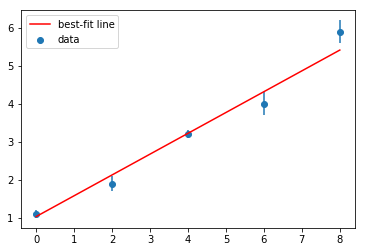

In [13]:
xf = linspace(min(x),max(x),100)
yf = a*xf + b
figure()
scatter(x,y,label='data')  # plot data
errorbar(x, y, yerr, ls='None')  # add error bars to data
plot(xf,yf,"r-",label='best-fit line')  # plot best-fit line
legend(loc='upper left')
show()

When plotting the data with errorbars in both directions, the array of uncertainties in the $y$ direction ($y2err$) comes before the array of uncertainties in the $x$ direction ($x2err$) in the  **`errorbar`** function. In this case, points were not plotted for the data because they would hide the smallest error bars.

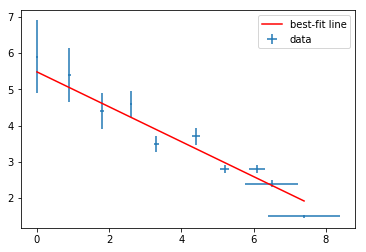

In [14]:
x2f = linspace(min(x2),max(x2),100)
y2f = a2*x2f + b2
figure()
errorbar(x2, y2, y2err, x2err, ls='None', label='data')  # plot data w/o points since some error bars are small
plot(x2f,y2f,"r-",label='best-fit line')  # plot best-fit line
legend(loc='upper right')
show()

The reduced chi squared and the degrees of freedom can also be used to judge the goodness of the fit. If $N$ is the number of data points and $C$ is  
the number of parameters (or constraints) in the fit, the number degrees of freedom is  
$$
d = N - C.
$$  
For a linear fit, $C = 2$ because there two parameters for a line. The reduced chi squared is defined as  
$$
\tilde{\chi}^{\, 2} = \frac{\chi^2}{d}.
$$  
According to Taylor (p. 271), “If we obtain a value of $\tilde{\chi}^{\, 2}$ of order one or less, then we have no reason to doubt our expected distribution; if we obtain a value of $\tilde{\chi}^{\, 2}$ much larger than one, our expected distribution is unlikely to be correct.”  
For an observed value (from fitting data) of the reduced chi square ($\tilde{\chi}^{\, 2}_o$), you can look up the probability of randomly getting a larger $\tilde{\chi}^{\, 2}$ with $d$ degrees of freedom on the table below (from Appendix D of Taylor’s book). A typical standard is to reject a fit if  
$$
Prob_d\left(\tilde{\chi}^{\, 2} \ge \tilde{\chi}^{\, 2}_o \right) < 5\%.
$$  
In other words, if the reduced chi squared for a fit is unlikely to occur randomly, then the fit is not a good one.  
In the first example above, five data points are fit with a line and $\tilde{\chi}^{\, 2} = 1.85$. Since $d = 5 - 2 = 3$, the table gives  

$$
Prob_d\left(\tilde{\chi}^{\, 2} \ge \tilde{\chi}^{\, 2}_o \right) \approx 14\%,
$$  
and there is no reason to reject the fit.

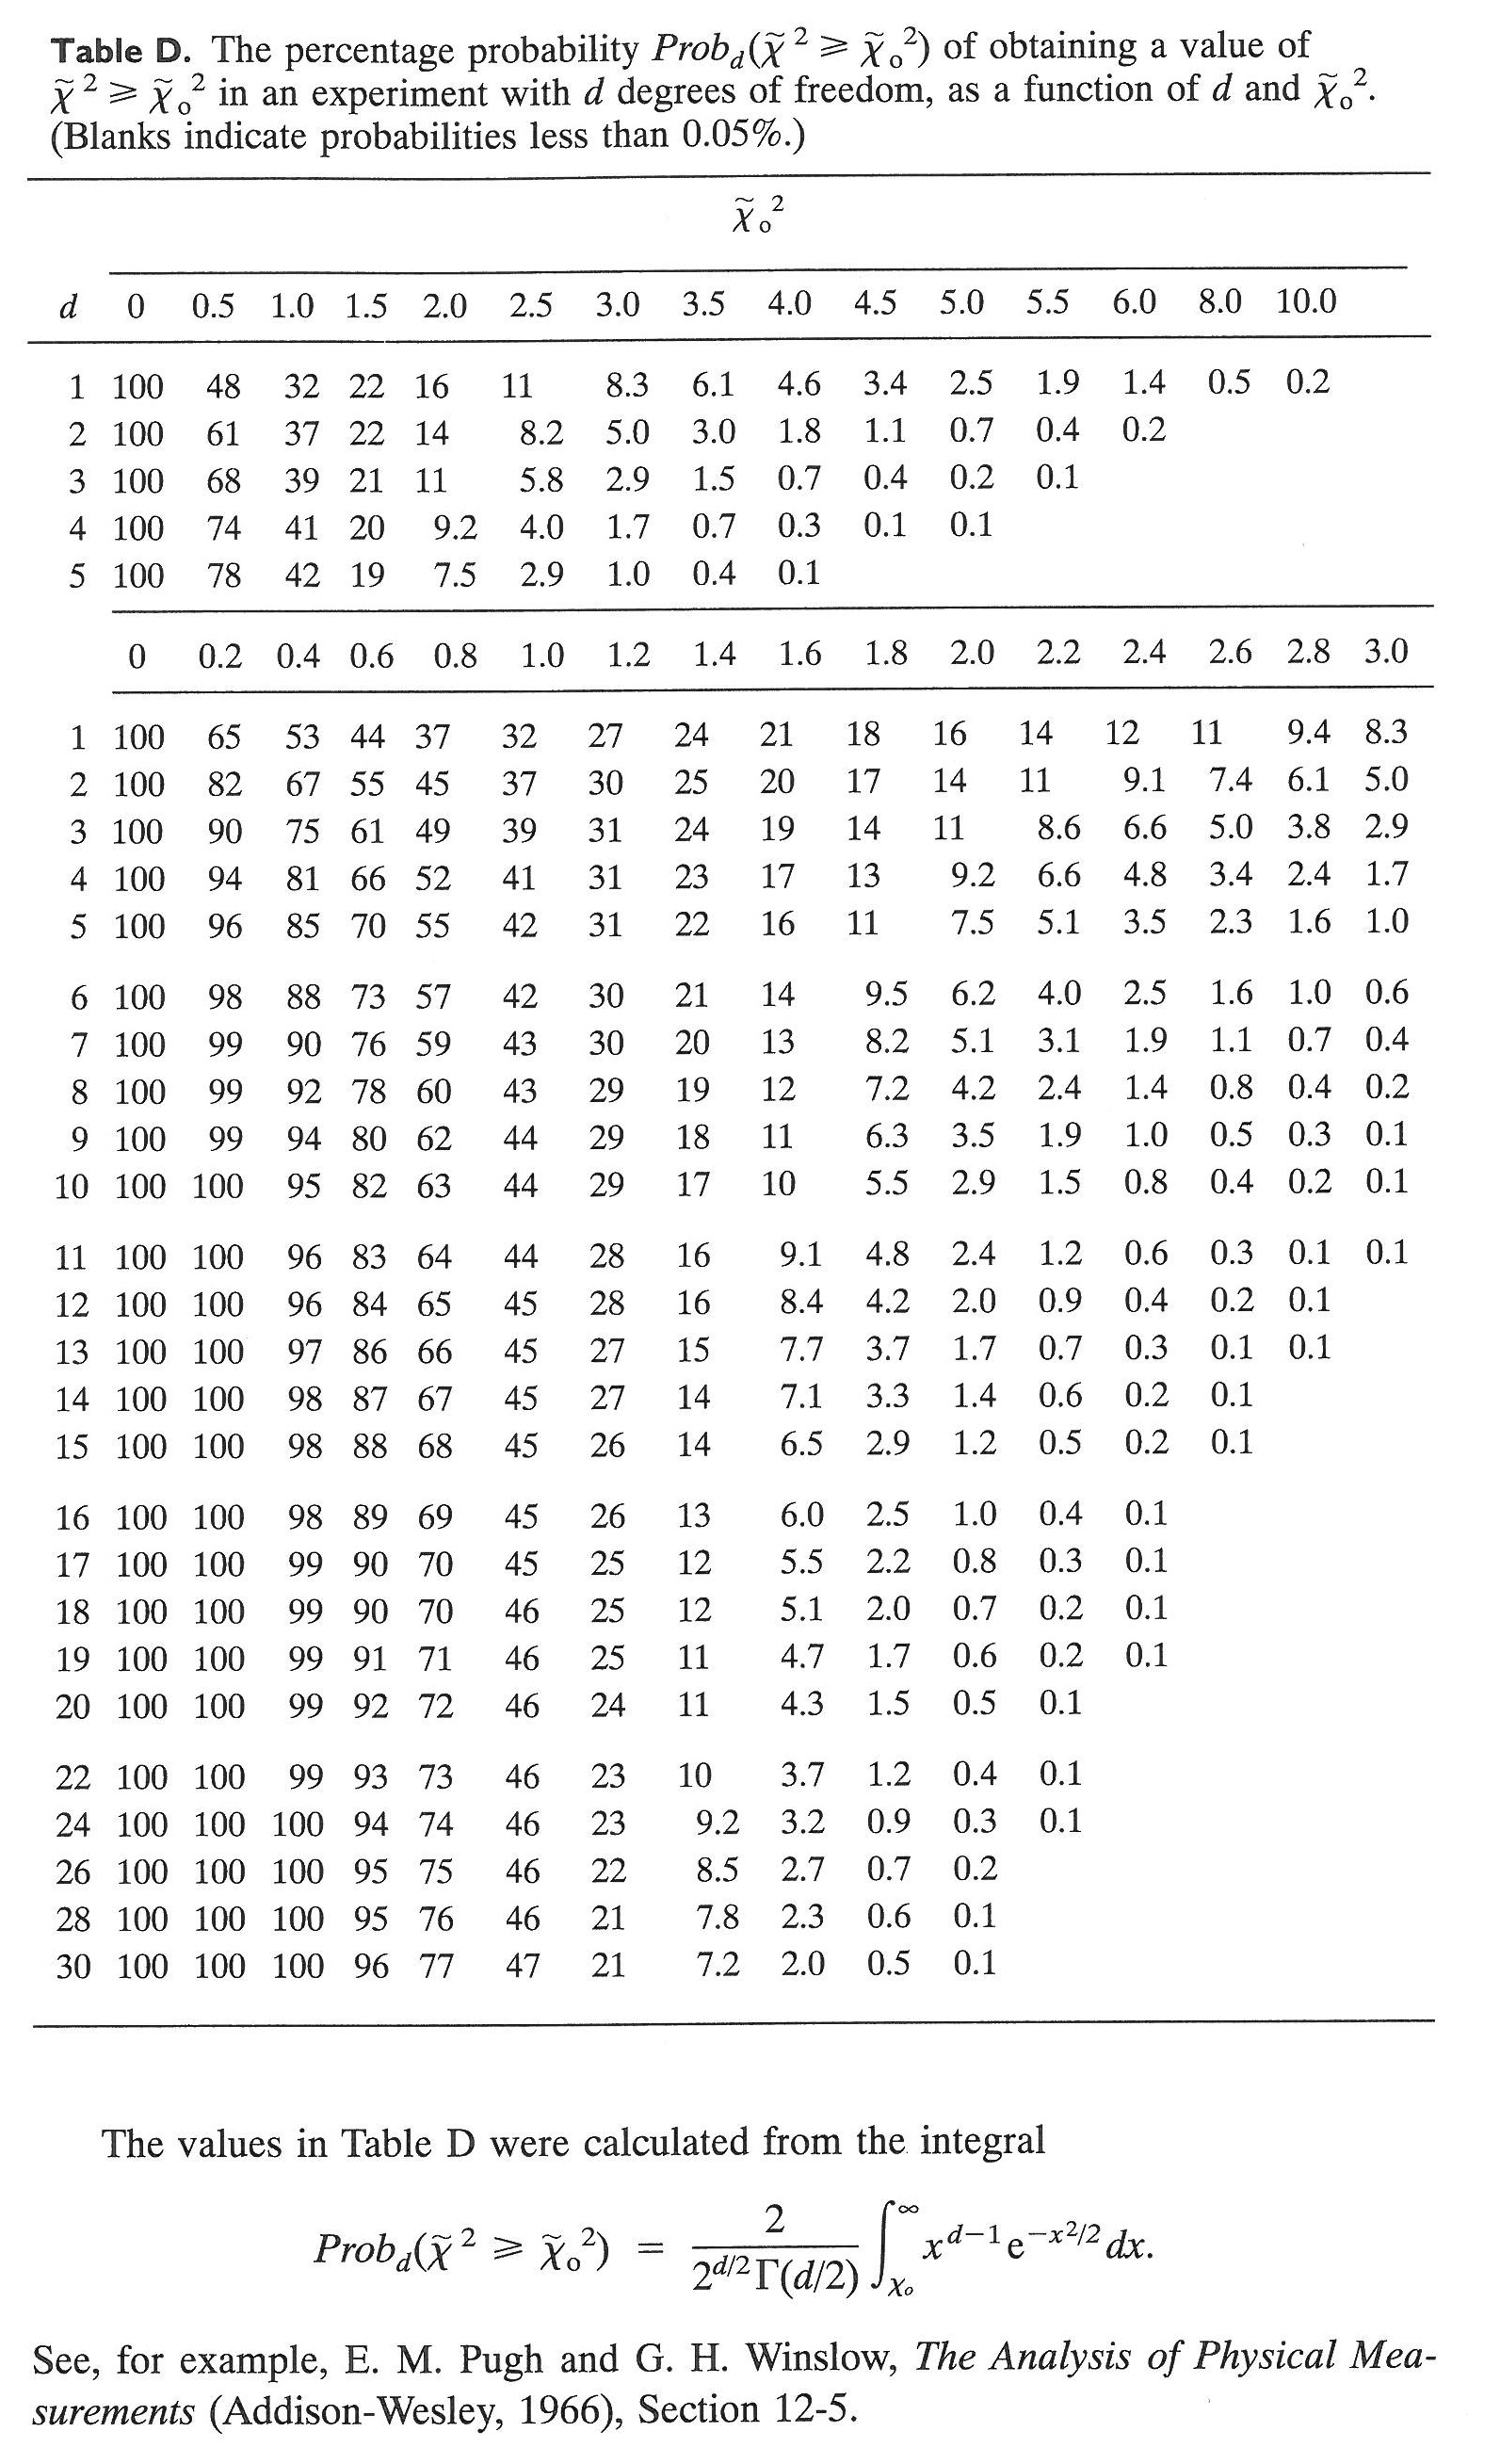

In [15]:
Image(filename="ChiSqTable-Taylor.jpg",width=600)

## Linearization

Some other functions with two parameters can be linearized so that a linear fit can be used. There are two common examples.  
First, if data is expected to fit an exponential function  
$$
y(x)=Ce^{Dx}, 
$$  
then  
$$
\ln y = Dx + \ln C.
$$  
Therefore, $\ln y$ vs. $x$ can be fit with a line in order to determine $C$ and $D$. Don’t forget that the uncertainty of $\ln y$ is not the same as the uncertainty of $y$. Also, the linear fit gives $\ln C$ and its uncertainty, which is not the same as the uncertainty of $C$. The uncertainties must be propagated correctly.  
Second, if data is expected to fit power law of the form
$$
y(x) = kx^n,
$$
then
$$
\log y = n \log x + \log k.
$$  
Note that the base 10 logarithm is typically used for power laws. In this case, $\log y$ vs. $\log x$ can be fit with a line. Don't forget that the uncertainties of $\log x$ and $\log y$ are not the same as the uncertainties of $x$ and $y$. The power $n$ is the slope, so its uncertainty comes directly from the fit. However, the uncertainty of the $\log k$ from the y intercept is not the same as the uncertainty of $k$. That uncertainty must be propagated.

## Additional Documentation

More information is available at:  
https://docs.scipy.org/doc/scipy/reference/odr.html